In [91]:
import gc
import time
import pandas as pd
import numpy as np
import torch
from torch import nn
import pytorch_model_summary as pms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
def dataloader(url):
    print("Loading Data")
    dataset = pd.read_pickle(url)
    labels = dataset.iloc[:, 16:]
    dataset = dataset.iloc[:, 4:16]

    _, weightindex = weight_metric()
    labels = labels[weightindex].to_numpy() #[:27]
    del weightindex
    gc.collect()


    print("Test Train Split 1")
    X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
    del dataset
    del labels


    # train-validation-test split = 60/20/20
    print("Test Train Split 2")
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    print("Loading Leads")
    X_train = lead_loader(X_train)
    X_val = lead_loader(X_val)
    X_test = lead_loader(X_test)

    print("Delete Missing Rows")
    X_train, y_train = delete_missing_rows(X_train, y_train)
    X_val, y_val = delete_missing_rows(X_val, y_val)
    X_test, y_test = delete_missing_rows(X_test, y_test)

    gc.collect()

    return X_train, X_test, y_train, y_test, X_val, y_val

# Convert ECG leads from Dataframe to NumPy array (used to convert to tensor later)
def lead_loader(dataset):

    dataset = dataset.to_numpy()
    print("Dataset shape: ", dataset.shape)
    testingleads = np.zeros([dataset.shape[0], dataset.shape[1], 5000])
    
    for i in range(0,12):
        for j in range(0, dataset.shape[0]):
            testingleads[j, i, :] = dataset[j, i]

    del dataset
    gc.collect()

    return testingleads

# Loading weight metric from challenge to use the 27 classes
def weight_metric():
    weights = pd.read_csv("../Data/weights.csv", index_col=0)
    ctcodes = pd.read_csv("../Data/Dx_map.csv")
    ctcodes = ctcodes.iloc[:, 1:]
    replacedict = dict(zip(ctcodes.iloc[:,0], ctcodes.iloc[:,1]))

    weights.columns = weights.columns.astype(int)
    weights.rename(columns=replacedict, index=replacedict, inplace=True)
    weightindex = np.array(weights.index)
    return weights, weightindex


# Delete rows where labels are missing
def delete_missing_rows(leads, labels):
    print("Deleting Rows/n")
    indexvals=[]
    for i in range(0, labels.shape[0]):
        if len(np.unique(labels[i,:], axis=0)) == 2:
            indexvals.append(i)
    leads = np.take(leads, indexvals, axis=0)
    labels = np.take(labels, indexvals, axis=0)

    del indexvals
    gc.collect()

    return leads, labels



trainingleads, testingleads, traininglabels, testinglabels, validationleads, validationlabels = dataloader("../Data/fullecgdata.pkl")


        

Loading Data
Test Train Split 1
Test Train Split 2
Loading Leads
Dataset shape:  (25860, 12)
Dataset shape:  (8620, 12)
Dataset shape:  (8621, 12)
Delete Missing Rows


### FULL TRAIN AND EVAL

In [136]:
# Using a function to apply 1d convolution where kernel_size=7
def conv3x1(in_planes, out_planes, stride=1):
    return nn.Conv1d(in_planes, out_planes, kernel_size=7, stride=stride,
                     padding=3, bias=False)

# Using a function to apply 1d convolution where kernel_size=1
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

# Residual Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x1(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x1(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dropout = nn.Dropout(.2)

    # Feed data through the network
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Bottleneck layer to reduce overfitting
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = conv3x1(planes, planes, stride)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm1d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dropout = nn.Dropout(.2)

    # Feed data through the network
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ResNet model (defining architecture)
class ResNet(nn.Module):
    # in_channel=number of leads, out_channel=number of classes
    def __init__(self, block, layers, in_channel=12, out_channel=27, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64 # Batch size
        self.conv1 = nn.Conv1d(in_channel, 64, kernel_size=5000, stride=2, padding=7,
                               bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, out_channel)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    # Feed data through the network
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# ResNet18 model
def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

# ResNet34 model
def resnet34(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model

# Training ResNet
def train(data, labels, validationleads, validationlabels, epochnum, threshval, opt, resnettype):
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"

    # Batch size
    batchval=64
    batchind = np.array(range(0, data.shape[0], batchval))
    #Initialise Model
    if resnettype == 18:
        model = resnet18().double()
    elif resnettype == 34:
        model = resnet34().double()
    model.cuda()
    # Array to store trained models
    models = []
    # Optimiser
    if opt == 0:
        optimiser = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-5)
    elif opt == 1:
        optimiser = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Initialise loss function
    criterion = nn.BCEWithLogitsLoss()
    # Model Save path
    model_save_path = "torch_models/"
    # Ndarray to store predicted labels
    pred_labels = np.zeros(shape=labels.shape)
    # Used to store models based on f-measure values
    prev_f_measure_val = 0.0
    # Arrays to store history of results
    f_measure_hist = np.ones(epochnum)
    training_loss_hist = []
    validation_loss_hist = []
    training_acc_hist = []
    validation_acc_hist = np.ones(epochnum)
    loss_batches = 0.0
    # Training phase
    for epoch in range(0, epochnum):
        model.train()
        print("TRAINING EPOCH {}".format(epoch))
        batchcounter = 0
        loss_epoch = 0.0
        loss = 0.0
        pred_labels = np.zeros(shape=labels.shape)
        epoch_training_loss = []
        # For each epoch, train on the training set
        with torch.set_grad_enabled(True):
            for i in batchind[:-1]:
                # training data - Numpy to Tensor
                x = torch.from_numpy(data[i:i+batchval,:,:] / 1000)
                x = x.cuda()
                
                # training labels - Numpy to Tensor
                trainlabels = torch.from_numpy(labels[i:i+batchval,:]).double()
                trainlabels = trainlabels.to(device=dev)
                
                # Reset gradients
                optimiser.zero_grad()
                
                # Make prediction
                y = model(x).to(dev)
                # Apply output layer function to predictions
                y_prob = torch.sigmoid(y)
                
                # Calculate loss
                loss = criterion(y, trainlabels)
                temploss = loss.item() * x.size(0)
                loss_epoch += temploss
                
                # Backwards step
                loss.backward()
                optimiser.step()
                
                # Calculate loss
                loss_batches += temploss
                batchcounter += x.size(0)
                current_loss = loss_batches / batchcounter

                # Store predictions and labels
                if i == 0:
                    all_train_labels = trainlabels
                    all_pred_prob = y_prob
                else:
                    all_train_labels = torch.cat((all_train_labels, trainlabels), 0)
                    all_pred_prob = torch.cat((all_pred_prob, y_prob), 0)

                # Covert predictions from tensor to numpy
                pred_labels[i:i+batchval,:] = y_prob.cpu().detach().numpy()

                # Apply threshold to predictions to recieve binary output
                pred_labels[pred_labels < threshval] = 0
                pred_labels[pred_labels > threshval] = 1

                # Calculate Training Accuracy
                training_acc = accuracy_score(labels[i:i+batchval,:], pred_labels[i:i+batchval,:])

                # Store Loss
                epoch_training_loss.append(current_loss)

                # Output current training information
                print("{}".format(time.strftime("%H:%M:%S", time.localtime())), ", Epoch: {} [{}/{}],".format(epoch,i+batchval,data.shape[0]), 
                "Loss: {}".format(current_loss), "Accuracy: {}".format(training_acc))
            
            training_acc_hist.append(training_acc)
            training_loss_hist.append(epoch_training_loss)
        
        # Generate confusion matrix
        conf_mat_train = multilabel_confusion_matrix(labels[:pred_labels.shape[0],:], pred_labels)
        class_report = classification_report(labels[:pred_labels.shape[0],:], pred_labels)
    


        # Evaluation mode (using validation set)
        model.eval()
        # Batch size
        val_batchval=64
        batchindval = np.array(range(0, validationleads.shape[0], val_batchval))
        valid_loss = 0.0 # Loss variable
        batchcounterval = 0 # batch counter variable
        val_pred_labels = np.zeros(shape=validationlabels.shape)
        epoch_validation_loss = []
        # Initialise loss function
        criterion = nn.BCEWithLogitsLoss()
        with torch.set_grad_enabled(False):
            for j in batchindval[:-1]:
                # validation leads - numpy to tensor
                x_val = torch.from_numpy(validationleads[j:j+val_batchval,:,:] / 1000)
                x_val = x_val.cuda()
                # validation labels - numpy to tensor
                val_labels = torch.from_numpy(validationlabels[j:j+val_batchval,:]).double().cuda()
                val_labels = val_labels.to(device=dev)

                # Make prediction
                val_y = model(x_val).to(device=dev)
                # Apply output layer function
                val_y_prob = torch.sigmoid(val_y)
                
                # Calculate loss
                val_loss = criterion(val_y, val_labels)
                valid_loss = val_loss.item() * x_val.size(0)
                batchcounterval += x_val.size(0)
                current_val_loss = valid_loss / batchcounterval

                # Store raw predictions
                if j == 0:
                    all_val_labels = val_labels
                    all_val_prob = val_y_prob
                else:
                    all_train_labels = torch.cat((all_val_labels, val_labels), 0)
                    all_pred_prob = torch.cat((all_val_prob, val_y_prob), 0)

                # Output predicted values from tensor to numpy
                val_pred_labels[j:j+val_batchval,:] = y_prob.cpu().detach().numpy()

                # Ouput current validation loss
                epoch_validation_loss.append(current_val_loss)
                print("Epoch: {}".format(epoch), "Validation Loss: {}".format(current_val_loss))
        
        # Calculating and Storing f-measure and validation accuracy
        validation_loss_hist.append(epoch_validation_loss)
        models.append(model)
        
        tempfmeasure = []
        tempaccmeasure = []


        val_pred_labels[val_pred_labels > threshval] = 1
        val_pred_labels[val_pred_labels < threshval] = 0
        
        val_pred_labels = val_pred_labels.astype(int)
        f_measure_val = f1_score(validationlabels, val_pred_labels, average='samples')
        validation_acc = accuracy_score(validationlabels, val_pred_labels)
        tempfmeasure.append(f_measure_val)
        tempaccmeasure.append(validation_acc)

        validation_acc_hist[epoch] = validation_acc

        f_measure_hist[epoch] = f_measure_val

        print("F-MEASURE ({}): {}".format(threshval, f_measure_val), "ACCURACY: {}".format(validation_acc))

        # Save model to path
        if f_measure_val > prev_f_measure_val:
            newmodelpath = model_save_path + "model_e" + str(epoch) + "_f" + str(f_measure_val) + ".pth"
            torch.save(model.state_dict(), newmodelpath)
            prev_f_measure_val = f_measure_val

    # print(challenge_metric_hist)    
    print("F-measure History: ", f_measure_hist)
    print("Accuracy History: ", validation_acc_hist)

    return training_loss_hist, validation_loss_hist, f_measure_hist, validation_acc_hist, conf_mat_train, class_report, models



training_loss_hist, validation_loss_hist, f_measure_hist, validation_acc_hist, conf_mat_train, class_report, models = train(trainingleads, traininglabels, validationleads, validationlabels, epochnum=1, threshval=0.35, opt=0, resnettype=34)




TRAINING EPOCH 0
02:06:28 , Epoch: 0 [64/22693], Loss: 0.716201428336262 Accuracy: 0.0
02:06:28 , Epoch: 0 [128/22693], Loss: 0.622020919574266 Accuracy: 0.0
02:06:29 , Epoch: 0 [192/22693], Loss: 0.5413420607581675 Accuracy: 0.0
02:06:30 , Epoch: 0 [256/22693], Loss: 0.48291406987081426 Accuracy: 0.0
02:06:31 , Epoch: 0 [320/22693], Loss: 0.4367429940066323 Accuracy: 0.0
02:06:32 , Epoch: 0 [384/22693], Loss: 0.39930014745514963 Accuracy: 0.03125
02:06:33 , Epoch: 0 [448/22693], Loss: 0.37218459750709415 Accuracy: 0.046875
02:06:33 , Epoch: 0 [512/22693], Loss: 0.3502240644374052 Accuracy: 0.09375
02:06:34 , Epoch: 0 [576/22693], Loss: 0.3330145130146082 Accuracy: 0.21875
02:06:35 , Epoch: 0 [640/22693], Loss: 0.3188814173284591 Accuracy: 0.296875
02:06:35 , Epoch: 0 [704/22693], Loss: 0.3090243739397188 Accuracy: 0.21875
02:06:36 , Epoch: 0 [768/22693], Loss: 0.29953946939812576 Accuracy: 0.265625
02:06:37 , Epoch: 0 [832/22693], Loss: 0.29153851731940783 Accuracy: 0.34375
02:06:38 ,

In [96]:
conf_mat_train.shape
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1418
           1       0.14      0.00      0.00      2062
           2       0.00      0.00      0.00       181
           3       0.00      0.00      0.00       188
           4       0.00      0.00      0.00       399
           5       0.00      0.00      0.00      1009
           6       0.27      0.00      0.01      1111
           7       0.17      0.00      0.00      3700
           8       0.17      0.01      0.02       627
           9       0.00      0.00      0.00       334
          10       0.00      0.00      0.00       603
          11       0.00      0.00      0.00       178
          12       0.00      0.00      0.00      1041
          13       0.00      0.00      0.00       126
          14       0.00      0.00      0.00       212
          15       0.00      0.00      0.00       918
          16       0.00      0.00      0.00       599
          17       0.00    

## TESTING FUNCTION

In [137]:
def test_eval(model, testingleads, testinglabels, threshval):
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    with torch.no_grad():
        model.cuda()
        # Batch size
        batchval=64
        batchind = np.array(range(0, testingleads.shape[0], batchval))
        test_pred_labels = np.zeros(shape=testinglabels.shape)

        for i in batchind[:-1]:
            # testing leads - numpy to tensor
            x = torch.from_numpy(testingleads[i:i+batchval,:,:] / 1000)
            x = x.cuda()

            # testing labels - numpy to tensor
            test_labels = torch.from_numpy(testinglabels[i:i+batchval,:]).double().cuda()

            # Make prediction
            y = model(x).to(device=dev)
            # Apply output layer function
            test_y_prob = torch.sigmoid(y)

            # Store predictions
            if i == 0:
                all_test_labels = test_labels
                all_test_pred_prob = test_y_prob
            else:
                all_test_labels = torch.cat((all_test_labels, test_labels), 0)
                all_test_pred_prob = torch.cat((all_test_pred_prob, test_y_prob), 0)

            # Get predicted labels in numpy format
            test_pred_labels[i:i+batchval,:] = test_y_prob.cpu().detach().numpy()

            test_pred_labels = test_pred_labels.astype(int)

            test_pred_labels[test_pred_labels > threshval] = 1
            test_pred_labels[test_pred_labels < threshval] = 0

            # Calculate Accuracy
            f_measure_temp_val = accuracy_score(testinglabels[i:i+batchval,:], test_pred_labels[i:i+batchval,:])
                
            # Print testing accuracy per batch
            print("Accuracy: {}".format(f_measure_temp_val))
        finalpred = all_test_pred_prob.cpu().detach().numpy()
        finalpred[finalpred > threshval] = 1
        finalpred[finalpred < threshval] = 0

        # Calculate weighted f-measure
        FMEASUREVAL = f1_score(testinglabels[:all_test_pred_prob.shape[0],:], finalpred, average='samples')
        # Ouput confusion matrix and classification report
        conf_mat_test = multilabel_confusion_matrix(testinglabels[:finalpred.shape[0],:], finalpred)
        test_class_report = classification_report(testinglabels[:finalpred.shape[0],:], finalpred)
        print(FMEASUREVAL)

        return conf_mat_test, test_class_report


testingmodel = models[0]

conf_mat_test, test_class_report = test_eval(testingmodel, testingleads, testinglabels, threshval=0.3)


F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.046875
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.046875
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.0625
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.078125
F-MEASURE (0.3): 0.046875
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.03125
F-MEASURE (0.3): 0.03125
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.03125
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.09375
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.03125
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.0625
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.0
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.03125
F-MEASURE (0.3): 0.046875
F-MEASURE (0.3): 0.046875
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.046875
F-MEASURE (0.3): 0.0625
F-MEASURE (0.3): 0.03125
F-MEASURE (0.3): 0.015625
F-MEASURE (0.3): 0.0156

In [113]:
x = torch.from_numpy(trainingleads[0:64,:,:]).cuda()
print(x.shape)
y = testingmodel(x)
pms.summary(testingmodel, x, max_depth=None, show_input=False, batch_size=64, print_summary=True)

torch.Size([64, 12, 5000])
----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param #
               Conv1d-1         [64, 64, 8]       3,840,000       3,840,000
          BatchNorm1d-2         [64, 64, 8]             128             128
                 ReLU-3         [64, 64, 8]               0               0
            MaxPool1d-4         [64, 64, 4]               0               0
               Conv1d-5         [64, 64, 4]          28,672          28,672
          BatchNorm1d-6         [64, 64, 4]             128             128
                 ReLU-7         [64, 64, 4]               0               0
              Dropout-8         [64, 64, 4]               0               0
               Conv1d-9         [64, 64, 4]          28,672          28,672
         BatchNorm1d-10         [64, 64, 4]             128             128
              Conv1d-11         [64, 64, 4]          28,672 

'----------------------------------------------------------------------------\n           Layer (type)        Output Shape         Param #     Tr. Param #\n============================================================================\n               Conv1d-1         [64, 64, 8]       3,840,000       3,840,000\n          BatchNorm1d-2         [64, 64, 8]             128             128\n                 ReLU-3         [64, 64, 8]               0               0\n            MaxPool1d-4         [64, 64, 4]               0               0\n               Conv1d-5         [64, 64, 4]          28,672          28,672\n          BatchNorm1d-6         [64, 64, 4]             128             128\n                 ReLU-7         [64, 64, 4]               0               0\n              Dropout-8         [64, 64, 4]               0               0\n               Conv1d-9         [64, 64, 4]          28,672          28,672\n         BatchNorm1d-10         [64, 64, 4]             128             1

(5, 354)


Text(0.5, 0, 'Batch Number')

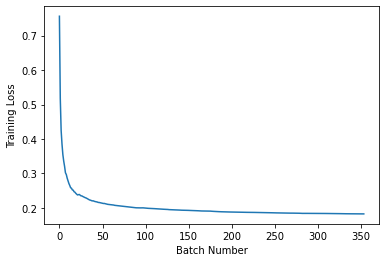

In [62]:
import matplotlib.pyplot as plt
xlist = np.array(training_loss_hist)
print(xlist.shape)

plt.plot(xlist[0,:])
plt.ylabel("Training Loss")
plt.xlabel("Batch Number")


In [37]:
def test_eval(path, testingleads, testinglabels):
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    with torch.no_grad():
        model = resnet18().double()
        model.cuda()
        model.load_state_dict(torch.load(path))
        model.eval()

        batchval=64
        batchind = np.array(range(0, testingleads.shape[0], batchval))

        for i in batchind[:-1]:

            x = torch.from_numpy(testingleads[i:i+batchval,:,:])
            x = x.cuda()

            test_pred_label = model(x)
            test_y_prob = torch.sigmoid(test_pred_label)

            testinglabels = torch.from_numpy(testinglabels[i:i+batchval,:]).double()
            testinglabels = testinglabels.to(device=dev)

            if i == 0:
                all_test_labels = testinglabels
                all_test_pred_prob = test_y_prob
            else:
                all_test_labels = torch.cat((all_test_labels, testinglabels), 0)
                all_test_pred_prob = torch.cat((all_test_pred_prob, test_y_prob), 0)





def evaluate(true_labels, pred_prob, threshold, weights, weightindex):
    true_labels = true_labels.cpu().detach().numpy().astype(int)
    labels = np.zeros(true_labels.shape)

    _, pred_label = torch.max(pred_prob, 1)
    pred_label = torch.unsqueeze(pred_label, 1)
    pred_label = pred_label.cpu().detach().numpy()

    labels[np.arange(true_labels.shape[0]), pred_label] = 1
    y_prob = pred_prob.cpu().detach().numpy()
    pred_prob = pred_prob.cpu().detach().numpy() >= threshold

    labels = labels + pred_label
    labels[labels > 1.1] = 1

    final_labels = true_labels
    bin_label_out = labels


    norm_class = "SNR"
    equiv_index = ["RBBB", "SVPB", "VPB"]

    final_classes = [elem for elem in weightindex if elem not in equiv_index]

    ind = np.any(weights, axis=0)  # Find indices of classes in weight matrix.
    final_classes = [j for i, j in enumerate(final_classes) if ind[i]]
    final_labels = final_labels[:, ind]
    binary_outputs = bin_label_out[:, ind]
    weights = weights[np.ix_(ind, ind)]

    challenge_metric_val = challenge_metric(weights, labels, binary_outputs, final_classes, norm_class)

    return challenge_metric_val


# Compute modified confusion matrix for multi-class, multi-label tasks.
def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0 / normalization

    return A


def challenge_metric(weights, labels, outputs, classes, normal_class):
    num_recordings, num_classes = np.shape(labels)
    normal_index = classes.index(normal_class)

    # Compute the observed score.
    A = compute_modified_confusion_matrix(labels, outputs)
    observed_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the correct label(s).
    correct_outputs = labels
    A = compute_modified_confusion_matrix(labels, correct_outputs)
    correct_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the normal class.
    inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)
    inactive_outputs[:, normal_index] = 1
    A = compute_modified_confusion_matrix(labels, inactive_outputs)
    inactive_score = np.nansum(weights * A)

    if correct_score != inactive_score:
        normalized_score = float(observed_score - inactive_score) / float(correct_score - inactive_score)
    else:
        normalized_score = float('nan')

    return normalized_score

In [20]:

model = resnet34().double()

x = torch.from_numpy(trainingleads[0:64,:,:])
print(x.shape)
y = model(x)
pms.summary(model, x, max_depth=None, show_input=False, batch_size=64, print_summary=True)


torch.Size([64, 12, 5000])
----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param #
               Conv1d-1         [64, 64, 8]       3,840,000       3,840,000
          BatchNorm1d-2         [64, 64, 8]             128             128
                 ReLU-3         [64, 64, 8]               0               0
            MaxPool1d-4         [64, 64, 4]               0               0
           BasicBlock-5         [64, 64, 4]          57,600          57,600
           BasicBlock-6         [64, 64, 4]          57,600          57,600
           BasicBlock-7         [64, 64, 4]          57,600          57,600
           BasicBlock-8        [64, 128, 2]         180,992         180,992
           BasicBlock-9        [64, 128, 2]         229,888         229,888
          BasicBlock-10        [64, 128, 2]         229,888         229,888
          BasicBlock-11        [64, 128, 2]         229,888 

'----------------------------------------------------------------------------\n           Layer (type)        Output Shape         Param #     Tr. Param #\n============================================================================\n               Conv1d-1         [64, 64, 8]       3,840,000       3,840,000\n          BatchNorm1d-2         [64, 64, 8]             128             128\n                 ReLU-3         [64, 64, 8]               0               0\n            MaxPool1d-4         [64, 64, 4]               0               0\n           BasicBlock-5         [64, 64, 4]          57,600          57,600\n           BasicBlock-6         [64, 64, 4]          57,600          57,600\n           BasicBlock-7         [64, 64, 4]          57,600          57,600\n           BasicBlock-8        [64, 128, 2]         180,992         180,992\n           BasicBlock-9        [64, 128, 2]         229,888         229,888\n          BasicBlock-10        [64, 128, 2]         229,888         229,8